### Import the CNN Util and libraries needed
We have the util to make it easy to create and try new variations of the CNN model and be consistent with how we're analyzing and evaluating it.

In [1]:
# Import necessary libraries
import cnn_utils
import tensorflow as tf
import numpy as np
from keras import layers, models, optimizers, callbacks
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, EfficientNetB0, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications import ResNet50V2
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import smart_resize
from keras.src.legacy.preprocessing.image import ImageDataGenerator


### Load the data

In [2]:
data_dict = cnn_utils.load_cifar10_from_tar()

Loading CIFAR-10 data...
Loading training batch 1...
Loading training batch 2...
Loading training batch 3...
Loading training batch 4...
Loading training batch 5...
Loading test data...
Raw data loaded successfully!
Training data shape: (50000, 3072)
Test data shape: (10000, 3072)
Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Preporcess the data

In [3]:
data = cnn_utils.preprocess_data(data_dict)

Preprocessing data...
Preprocessing completed!
Training: (45000, 32, 32, 3), Validation: (5000, 32, 32, 3), Test: (10000, 32, 32, 3)


### Let's do a quick visualization of sample images (to also ensure we still have the correct shape)

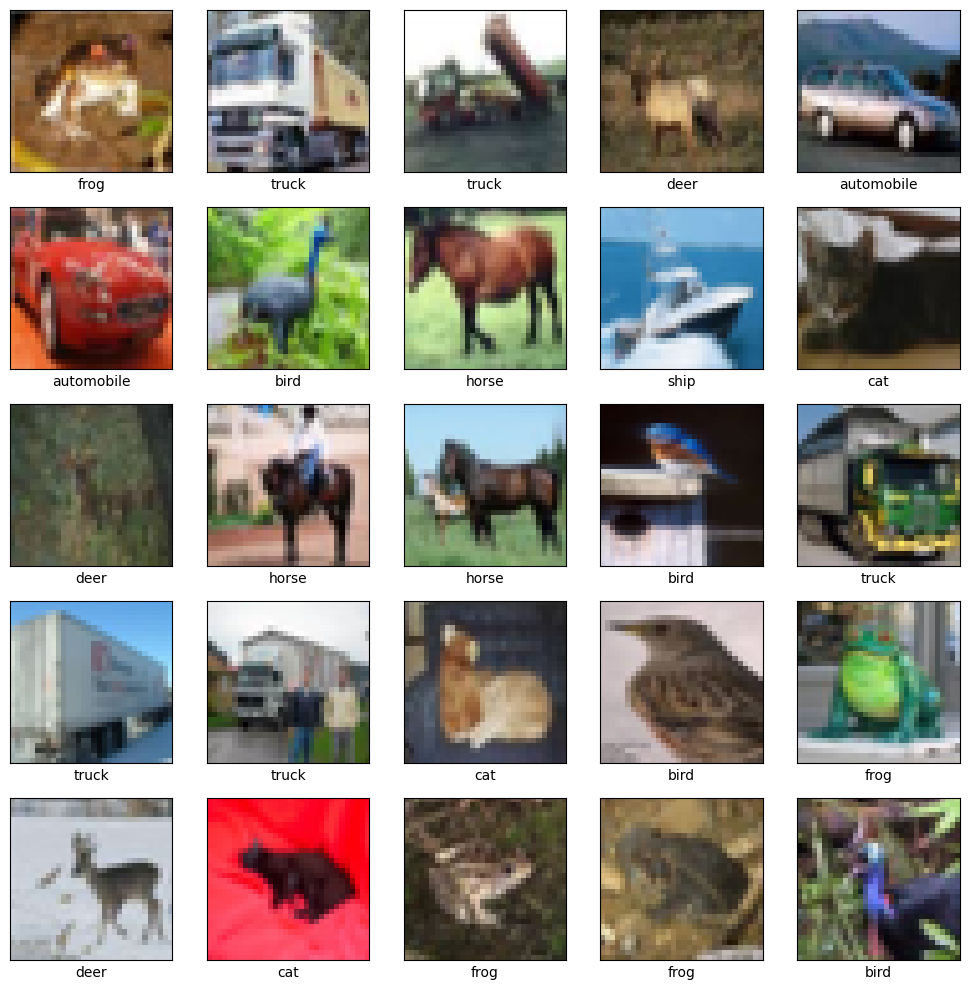

In [4]:
cnn_utils.visualize_data_samples(data)


### Data processing for Transfer Learning
- Converts back to [0, 255]: Your data was normalized to [0, 1], but ImageNet pre-trained models expect the original [0, 255] pixel range
- Applies ImageNet preprocessing: Uses preprocess_input() which applies model-specific normalization (e.g., ResNet uses different normalization than VGG)

In [5]:
#print("Resizing only validation and test sets (training will be handled by augmentation)...")

# Only resize val and test sets (much smaller)
#data['X_val'] = tf.image.resize(data['X_val'], [224, 224]).numpy()
#data['X_test'] = tf.image.resize(data['X_test'], [224, 224]).numpy()

#print("Val and test resizing completed!")
#print(f"Shapes - Train: {data['X_train'].shape} (32x32), Val: {data['X_val'].shape} (224x224), Test: {data['X_test'].shape} (224x224)")

### Data Augmentation

Moderate geometric augmentation that applies realistic transformations to training images:
- Rotation (±15°), shifting (10% in each direction), and zooming (±10%) simulate natural camera angle and distance variations
- Horizontal flipping doubles the dataset by creating mirror images (works well for CIFAR-10 since objects like cars/planes look realistic when flipped)


In [6]:
# Custom data generator that handles resizing
from tensorflow.keras.utils import Sequence

class ResizingDataGenerator(Sequence):
    def __init__(self, x, y, batch_size=32, shuffle=True, augment=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]

        # Resize to 224x224 - THIS IS THE KEY STEP!
        batch_x_resized = tf.image.resize(batch_x, [224, 224])

        # Apply simple augmentation
        if self.augment:
            # Add some basic augmentation here if needed
            pass

        return batch_x_resized, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create the generators
train_generator = ResizingDataGenerator(data['X_train'], data['y_train'], batch_size=32)
val_generator = ResizingDataGenerator(data['X_val'], data['y_val'], batch_size=32, shuffle=False)

print("Custom generators created with automatic resizing to 224x224")

Custom generators created with automatic resizing to 224x224


### Let's define our CNN model (architecture)
Deeper, more sophisticated architecture for higher accuracy
Structure:
- 3 convolutional blocks (64→128→256 filters)
- BatchNormalization after each conv layer
- Progressive dropout (0.3→0.4→0.5)
- Large dense layer (512 neurons)

### Create transfer model

In [7]:
def create_transfer_model(base_model_name='resnet50', num_classes=10):
    """
    Create transfer learning model with frozen base and custom classifier
    """
    # Choose base model
    if base_model_name == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'efficientnet':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    elif base_model_name == 'resnet50v2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    base_model.trainable = False

    # Build the complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# Create the model
model, base_model = create_transfer_model('resnet50v2')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_utils.print_model_summary(model)

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,837,066 (90.93 MB)

 Trainable params: 267,914 (1.02 MB)

 Non-trainable params: 23,569,152 (89.91 MB)


📊 Total Parameters: 23,837,066


In [8]:
callbacks = [
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-7)
]

### Phase 1 Training (Frozen Base)


In [9]:
print("=== PHASE 1: Training classifier with frozen base ===")

# Train using the custom generator instead of cnn_utils.train_model
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

=== PHASE 1: Training classifier with frozen base ===
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 132s 82ms/step - accuracy: 0.7034 - loss: 0.8978 - val_accuracy: 0.8470 - val_loss: 0.4407 - learning_rate: 0.0010
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.8095 - loss: 0.5515 - val_accuracy: 0.8554 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.8215 - loss: 0.5136 - val_accuracy: 0.8602 - val_loss: 0.4008 - learning_rate: 0.0010
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.8246 - loss: 0.5041 - val_accuracy: 0.8688 - val_loss: 0.3870 - learning_rate: 0.0010
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 111s 79ms/step - accuracy: 0.8312 - loss: 0.4864 - val_accuracy: 0.8718 - val_loss: 0.3801 - learning_rate: 0.0010
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.8321 - loss: 0.4800 - val_accuracy: 0.8720 - val_loss: 0.3741 - learning_rate: 0.0010
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 

### Phase 2 Training (Fine-tuning)

In [10]:
print("=== PHASE 2A: Partial unfreezing (last 50 layers) ===")

# Unfreeze only the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with higher learning rate for partial fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Higher than before
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train with partial unfreezing
# Phase 2A
history_phase2a = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

print("=== PHASE 2B: Full fine-tuning (all layers) ===")

# Unfreeze all layers
base_model.trainable = True

# Recompile with very low learning rate for full fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with all layers unfrozen
# Phase 2B
history_phase2b = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

=== PHASE 2A: Partial unfreezing (last 50 layers) ===
Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 237s 152ms/step - accuracy: 0.8574 - loss: 0.4293 - val_accuracy: 0.9278 - val_loss: 0.2168 - learning_rate: 1.0000e-04
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 143ms/step - accuracy: 0.9443 - loss: 0.1658 - val_accuracy: 0.9304 - val_loss: 0.2149 - learning_rate: 1.0000e-04
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 201s 143ms/step - accuracy: 0.9661 - loss: 0.1028 - val_accuracy: 0.9332 - val_loss: 0.2039 - learning_rate: 1.0000e-04
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 201s 143ms/step - accuracy: 0.9768 - loss: 0.0705 - val_accuracy: 0.9236 - val_loss: 0.2466 - learning_rate: 1.0000e-04
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 202s 144ms/step - accuracy: 0.9796 - loss: 0.0634 - val_accuracy: 0.9316 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 201s 143ms/step - accuracy: 0.9841 - loss: 0.0507 - val_accuracy: 0.9328 - val_loss: 0.2405 - 

### Combined History

In [11]:
# Combine all three training phases
def combine_three_histories(hist1, hist2a, hist2b):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2a.history[key] + hist2b.history[key]

    class CombinedHistory:
        def __init__(self, history_dict):
            self.history = history_dict

    return CombinedHistory(combined)

# Combine all training phases
combined_history = combine_three_histories(history_phase1, history_phase2a, history_phase2b)

### Let's show the evaluation result

MODEL EVALUATION


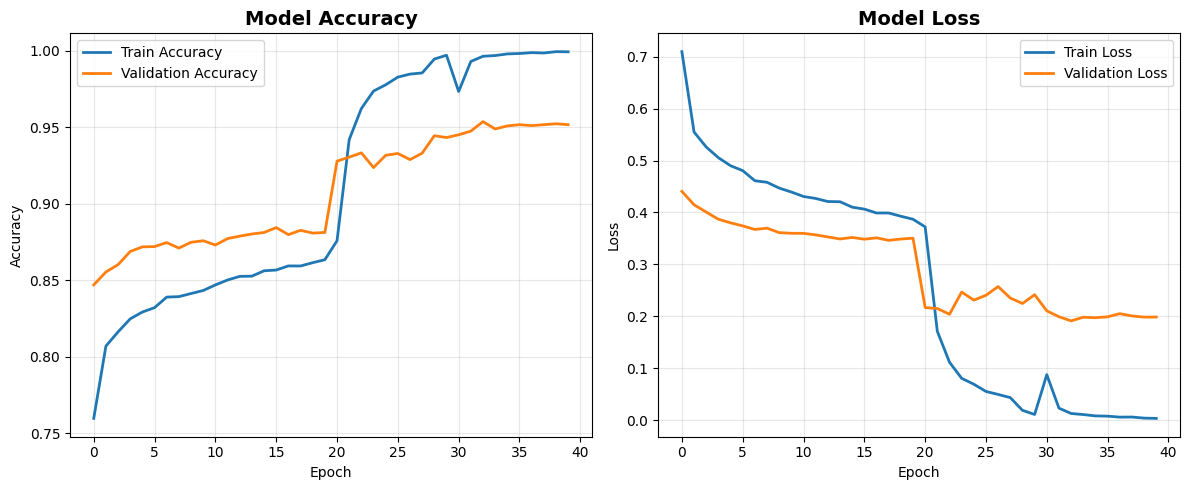

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9527 - loss: 0.2224

🎯 Final Test Results:
   Test Accuracy: 0.9522
   Test Loss: 0.2135
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step

📊 Classification Report:
              precision    recall  f1-score   support

    airplane       0.97      0.97      0.97      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.93      0.94      1000
         cat       0.89      0.90      0.90      1000
        deer       0.94      0.95      0.94      1000
         dog       0.91      0.92      0.91      1000
        frog       0.97      0.98      0.97      1000
       horse       0.97      0.96      0.96      1000
        ship       0.97      0.97      0.97      1000
       truck       0.97      0.97      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



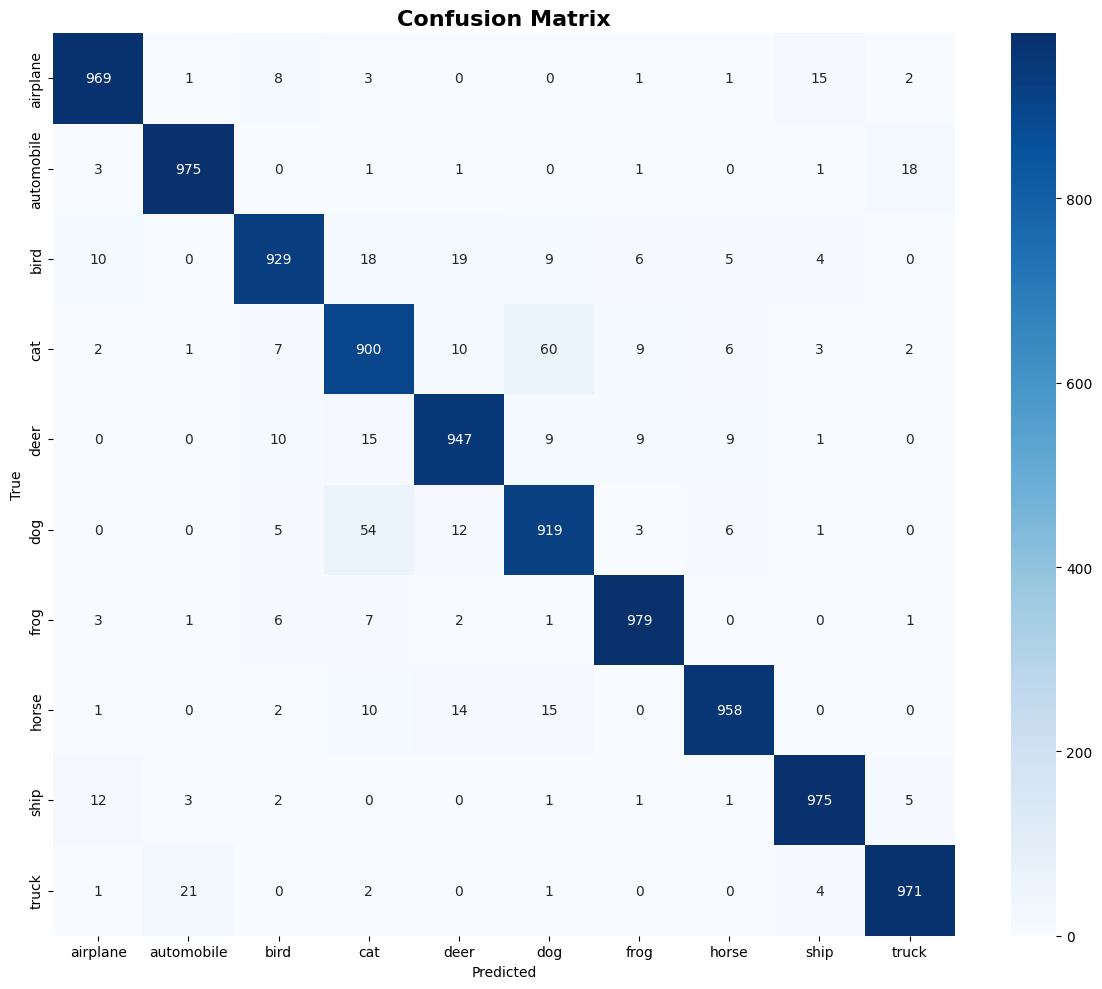

Evaluation completed!


In [13]:
# Create test generator
test_generator = ResizingDataGenerator(data['X_test'], data['y_test'], batch_size=32, shuffle=False, augment=False)

# Manual evaluation instead of cnn_utils.evaluate_model()
print("=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Plot training history first
cnn_utils.plot_training_history(combined_history)

# Evaluate on test set using the generator
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"\n🎯 Final Test Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test Loss: {test_loss:.4f}")

# Generate predictions using the generator
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(data['y_test'], axis=1)

# Classification report
from sklearn.metrics import classification_report
print(f"\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes,
                          target_names=data['label_names']))

# Confusion matrix
cnn_utils.plot_confusion_matrix(y_true_classes, y_pred_classes, data['label_names'])

print("Evaluation completed!")

In [14]:
# Save the trained model
model.save('transfer_learning_resnet50v2.keras')
print("Model saved as 'transfer_learning_resnet50v2.keras'")

Model saved as 'transfer_learning_resnet50v2.keras'
